In [1]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

In [2]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl

/tmp/ipykernel_24209/1105938615.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


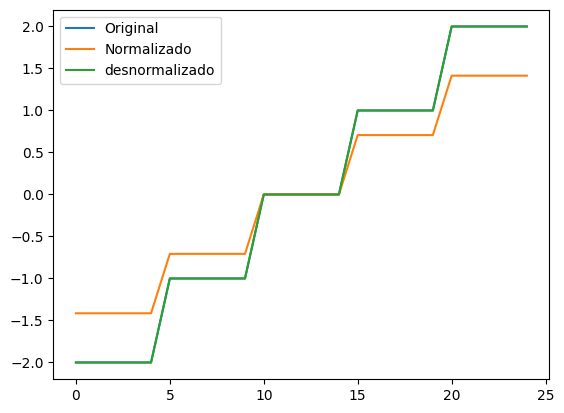

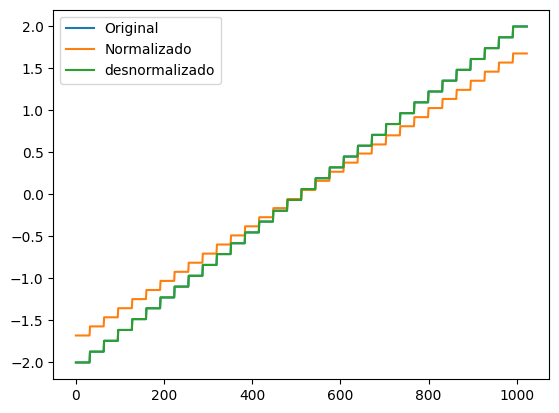

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def peaks(grid):
    x = np.linspace(-2, 2, grid)
    y = np.linspace(-2, 2, grid)
    x, y = np.meshgrid(x, y)
    z = 3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3 * np.exp(-(x+1)**2 - y**2)
    return x, y, z

def create_dataframe(grid):
   x, y, z = peaks(grid)
   data = {'X': x.flatten(), 'Y': y.flatten(), 'Z': z.flatten()}
   df = pd.DataFrame(data)
   return df

def show_norm(df, label="Peaks", plot=False):
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["Y"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()


df_25 = create_dataframe(grid=5)
df_25_norm = show_norm(df_25)
test_out_scaler(df_25)

df_1000 = create_dataframe(grid=32)
df_1000_norm = show_norm(df_1000)
test_out_scaler(df_1000)



In [4]:
def split_df(df):
    _input = np.vstack([df['X'], df['Y']]).T
    _output = np.array(df['Z'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer
        
        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-05-03 18:43:53.748276: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-03 18:43:53.778617: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 18:43:53.778665: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 18:43:53.779815: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-03 18:43:53.785668: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-03 18:43:53.786204: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [12]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error


class TrainWithSmallDataset:
    def __init__(self, batch_size=1000, store=25):
        self.batch_size = batch_size
        self.betters = []
        self.store = store

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output, sup_input, sup_output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(sup_input, sup_output)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
      self._sup = (sup_input, sup_output)

 
    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)

    
    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          vt_pred = self.lm_model.predict(self.vt_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          self.pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))    
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, self.pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_vt = r2_score(vt_denorm,  vt_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, self.pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)

          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'r2_vt': r2_vt,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mse_vt': mse_vt
                          }

          return metrics

In [17]:
import pickle
from itertools import product

class Tester:
  def __init__(self, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input_25, self.output_25 = split_df(df_25_norm)
    self.input_1000, self.output_1000 = split_df(df_1000_norm)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input_25, self.output_25, self.input_1000, self.output_1000)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando com 25 dados


In [19]:
tester = Tester(run_times=2, dataset_run_times=2)
tester.Loop(sort_by='mse_sup',
            boundarie = 1.0,
            hidden_sizes = [[5, 6], [2, 7], [6, 3]],
            regularizers=[0.02, 0.2, 0.5],
            learning_rate=[0.01, 0.1])

Testando combinacao1: Hidden Size=[5, 6], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  104
32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt
model_1_0_0,0.637789,0.536373,-6.593042,0.497827,0.207204,0.514105,0.658051,1.301287,1.345825,1.323556


DataFrame salvo em ../results/metrics_1_0
+++++++++++ [1_1] | 1 ++++++++++++++++++
Stopped at epoch:  67
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt
model_1_1_1,0.851968,0.762118,0.870759,-0.410860,0.764722,0.210110,0.337640,0.336325,0.333064,0.334695
model_1_1_0,0.850410,0.760542,0.870912,-0.415722,0.764459,0.212322,0.339875,0.335925,0.334212,0.335069


DataFrame salvo em ../results/metrics_1_1
Testando combinacao2: Hidden Size=[5, 6], regularizer=0.02, learning_rate=0.1
+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt
model_2_0_1,0.525924,0.486834,-4.641406,0.439317,-0.142035,0.672881,0.728365,1.505522,1.133332,1.319427
model_2_0_0,0.517202,0.483884,-3.894649,0.454457,-0.042544,0.685261,0.732552,1.306235,1.102728,1.204482


DataFrame salvo em ../results/metrics_2_0
+++++++++++ [2_1] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt
model_2_1_1,0.736845,0.624081,0.313379,0.740711,0.784104,0.373510,0.533563,0.037580,0.565058,0.301319
model_2_1_0,0.695025,0.597813,-0.596102,0.727227,0.755745,0.432867,0.570846,0.087357,0.594443,0.340900


DataFrame salvo em ../results/metrics_2_1
Testando combinacao3: Hidden Size=[5, 6], regularizer=0.2, learning_rate=0.01
+++++++++++ [3_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt
model_3_0_0,0.3619,0.311709,0.512888,-6.844815,0.248333,0.90569,0.976928,0.41382,0.496939,0.455379


DataFrame salvo em ../results/metrics_3_0
+++++++++++ [3_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt
model_3_1_1,0.385495,0.332030,-4.242746,0.430802,-0.204049,0.872201,0.948087,0.843228,0.570358,0.706793
model_3_1_0,0.373500,0.321622,-4.304924,0.412737,-0.227985,0.889225,0.962858,0.853228,0.588460,0.720844


DataFrame salvo em ../results/metrics_3_1
Testando combinacao4: Hidden Size=[5, 6], regularizer=0.2, learning_rate=0.1
+++++++++++ [4_0] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt
model_4_0_1,0.504436,0.457524,-0.811753,-0.026467,0.289164,0.703380,0.769966,0.911358,1.537140,1.224249
model_4_0_0,0.367520,0.351147,-1.321361,-0.217834,0.131547,0.897713,0.920953,1.167704,1.823712,1.495708


DataFrame salvo em ../results/metrics_4_0
+++++++++++ [4_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt
model_4_1_1,0.631854,0.617130,0.81458,0.36593,0.471456,0.522530,0.543428,0.066607,1.379246,0.722926
model_4_1_0,0.532185,0.495349,-0.07672,0.31441,0.313447,0.663996,0.716279,0.386780,1.491314,0.939047


DataFrame salvo em ../results/metrics_4_1
Testando combinacao5: Hidden Size=[5, 6], regularizer=0.5, learning_rate=0.01
+++++++++++ [5_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt
model_5_1_1,0.382034,0.353570,-0.098163,0.308919,0.335894,0.877113,0.917514,0.535227,2.114447,1.324837
model_5_1_0,0.365039,0.336735,-0.121435,0.287055,0.316285,0.901234,0.941409,0.546569,2.181342,1.363955


DataFrame salvo em ../results/metrics_5_1
Testando combinacao6: Hidden Size=[5, 6], regularizer=0.5, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt
model_6_1_1,0.832727,0.464726,-0.264032,0.935693,0.781337,0.237420,0.759744,0.167231,0.056737,0.111983
model_6_1_0,0.785906,0.410948,-1.031411,0.959504,0.702727,0.303876,0.836074,0.268754,0.035729,0.152242


DataFrame salvo em ../results/metrics_6_1
Testando combinacao7: Hidden Size=[2, 7], regularizer=0.02, learning_rate=0.01
+++++++++++ [7_0] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
Testando combinacao8: Hidden Size=[2, 7], regularizer=0.02, learning_rate=0.1
+++++++++++ [8_0] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_1] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt
model_8_1_1,0.607216,0.386705,-7.779108,-3.137969,-1.430213,0.557501,0.870483,1.201204,0.664200,0.932702
model_8_1_0,0.448704,0.382435,-3.922250,-0.041308,-0.095160,0.782484,0.876543,0.673488,0.167144,0.420316


DataFrame salvo em ../results/metrics_8_1
Testando combinacao9: Hidden Size=[2, 7], regularizer=0.2, learning_rate=0.01
+++++++++++ [9_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
Testando combinacao10: Hidden Size=[2, 7], regularizer=0.2, learning_rate=0.1
+++++++++++ [10_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt
model_10_0_0,0.396145,0.383206,-2.751339,0.382097,0.338946,0.857084,0.875449,0.249982,0.608131,0.429057


DataFrame salvo em ../results/metrics_10_0
+++++++++++ [10_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt
model_10_1_1,0.532374,0.44735,-0.420532,-0.660117,-0.436706,0.663727,0.784407,1.119853,0.438017,0.778935
model_10_1_0,0.572886,0.39081,0.567788,0.537120,0.573142,0.606227,0.864656,0.340727,0.122130,0.231428


DataFrame salvo em ../results/metrics_10_1
Testando combinacao11: Hidden Size=[2, 7], regularizer=0.5, learning_rate=0.01
+++++++++++ [11_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
Testando combinacao12: Hidden Size=[2, 7], regularizer=0.5, learning_rate=0.1
+++++++++++ [12_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt
model_12_1_0,0.478999,0.386058,0.587353,-2.99345,0.249264,0.739485,0.871402,0.353508,0.694389,0.523948


DataFrame salvo em ../results/metrics_12_1
Testando combinacao13: Hidden Size=[6, 3], regularizer=0.02, learning_rate=0.01
+++++++++++ [13_0] | 1 ++++++++++++++++++
Stopped at epoch:  716
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt
model_13_0_0,0.804355,0.751574,-2.344495,0.872936,0.273431,0.277690,0.352604,1.490777,0.244781,0.867779
model_13_0_1,0.804333,0.751552,-2.345068,0.872968,0.273350,0.277721,0.352636,1.491032,0.244719,0.867875


DataFrame salvo em ../results/metrics_13_0
+++++++++++ [13_1] | 1 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt
model_13_1_1,0.844733,0.811058,-0.619020,0.995459,0.467841,0.220379,0.268176,0.832184,0.001876,0.417030
model_13_1_0,0.844407,0.809791,-0.603508,0.996549,0.473216,0.220841,0.269974,0.824211,0.001426,0.412818


DataFrame salvo em ../results/metrics_13_1
Testando combinacao14: Hidden Size=[6, 3], regularizer=0.02, learning_rate=0.1
+++++++++++ [14_0] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_1] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_1] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
Testando combinacao15: Hidden Size=[6, 3], regularizer=0.2, learning_rate=0.01
+++++++++++ [15_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt
model_15_0_1,0.387483,0.375224,-0.767778,-0.597908,0.143893,0.869379,0.886779,0.410896,0.345472,0.378184
model_15_0_0,0.344097,0.342651,-1.067406,-0.737731,0.030849,0.930960,0.933011,0.480541,0.375702,0.428121


DataFrame salvo em ../results/metrics_15_0
+++++++++++ [15_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt
model_15_1_1,0.408667,0.392688,-0.599135,0.732489,0.522421,0.839311,0.861991,0.361522,0.303097,0.332309
model_15_1_0,0.397801,0.383832,-0.619871,0.728776,0.516030,0.854735,0.874562,0.366210,0.307303,0.336756


DataFrame salvo em ../results/metrics_15_1
Testando combinacao16: Hidden Size=[6, 3], regularizer=0.2, learning_rate=0.1
+++++++++++ [16_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt
model_16_0_0,0.57556,0.523914,-0.189828,0.43434,0.326178,0.602432,0.675736,0.996367,1.603806,1.300087


DataFrame salvo em ../results/metrics_16_0
+++++++++++ [16_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt
model_16_1_1,0.690862,0.656873,0.288864,0.428152,0.406919,0.438777,0.487019,0.44014,0.737204,0.588672
model_16_1_0,0.652814,0.610693,0.389684,0.449335,0.452110,0.492780,0.552565,0.37774,0.709896,0.543818


DataFrame salvo em ../results/metrics_16_1
Testando combinacao17: Hidden Size=[6, 3], regularizer=0.5, learning_rate=0.01
+++++++++++ [17_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_1] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
Testando combinacao18: Hidden Size=[6, 3], regularizer=0.5, learning_rate=0.1
+++++++++++ [18_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 